In [71]:
# Useful starting lines
%matplotlib inline

import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from test_utils import test
import time


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Support Vector Machines
## Classification Using SVM
Load dataset. We will use a toy dataset from sklearn.

In [6]:
from sklearn import datasets

# Load dataset
sklearn_dataset = datasets.load_breast_cancer()
Xx = sklearn_dataset.data
y = sklearn_dataset.target * 2 - 1  # labels must be in {-1, 1} for the hinge loss
X = np.ones((Xx.shape[0], Xx.shape[1] + 1))
X[:, :-1] = Xx
print("(N, D) =", X.shape)

(N, D) = (569, 31)


## Prepare cost and prediction functions

In [118]:
def calculate_primal_objective(y, X, w, lambda_):
    """compute the full cost (the primal objective, equation (1) in the exercise pdf),
        that is loss plus regularizer.

    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)

    Returns:
        scalar, non-negative

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_primal_objective(y_test, x_test, w_test, 1)
    31.0
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ***************************************************
    N = len(y)
    regularizer = lambda_/2 * w @ w.T
    z = 1 - y * (X @ w) # calc the 1 - z = 1 - (y_n * x_n.T @ w)
    maxs = np.max(z[:, np.newaxis], initial=0, axis=1) # get all the max, with initial as 0 ~ max(0, z_i)
    return np.mean(maxs) + regularizer

In [119]:
test(calculate_primal_objective)

✅ Your `calculate_primal_objective` passed 4 tests.


In [59]:
def calculate_accuracy(y, X, w):
    """compute the accuracy on the given dataset (X, y) using the model w.

    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)

    Returns:
        scalar, between 0 and 1

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_accuracy(y_test, x_test, w_test)
    0.5
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ***************************************************
    pred = X@w
    pred[pred >= 0] = 1
    pred[pred < 0] = -1
    
    return np.sum(pred == y) / len(y)

In [60]:
test(calculate_accuracy)

✅ Your `calculate_accuracy` passed 4 tests.


## Stochastic Gradient Descent for SVM

Compute the (stochastic) subgradient for the n-th summand of the SVM optimization objective

In [100]:
def subgrad(q):
    """
    Compute the subgrad for the hinge loss
    -1 if q_n < 1 0 otherwise
    
    Args:
        q: The matrix corresponding to y*X @ w, shape = (num_examples)
        
    Returns:
          numpy array, shape = (num_examples) composed only of {-1, 0}  
    """
    return -1 if q < 1 else 0

In [133]:

def calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples):
    """compute the stochastic gradient of loss plus regularizer.

    Args:
        X: the dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)
        lambda_: positive scalar number
        n: the index of the (one) datapoint we have sampled
        num_examples: N

    Returns:
        numpy array, shape = (num_features)

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_stochastic_gradient(y_test, x_test, w_test, 1, 1, 2)
    array([ 4,  6, 11])
    """

    x_n, y_n = X[n], y[n]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ***************************************************
    reg_grad = lambda_ * w
    z = y_n * (x_n @ w) # shape = (1, num_features) @ (num_features, ) => (1, )
    grad_q = y_n * x_n # shape = (1, num_features)

    return grad_q * subgrad(z) + reg_grad # 1/N = 1/1 = 1, as we only take 1 sample, so we don't need to calculate it
    

In [134]:
test(calculate_stochastic_gradient)

✅ Your `calculate_stochastic_gradient` passed 4 tests.


Implement stochastic gradient descent: Pick a data point uniformly at random and update w based on the gradient for the n-th summand of the objective

Final training accuracy = 89.63 %
Training time: 4.0 seconds 


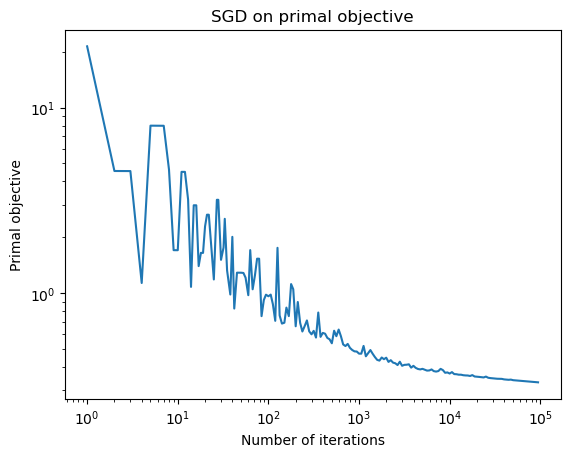

In [139]:
def sgd_for_svm_demo(y, X):
    xs = np.unique(np.round(np.logspace(0, 5, 201)))[:-1]
    max_iter = int(1e5)
    gamma = 1e-4
    lambda_ = 5e1

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    costs = []
    start = time.time()

    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0, num_examples - 1)

        grad = calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples)
        w -= gamma / (it + 1) * grad

        cost = calculate_primal_objective(y, X, w, lambda_)

        if it in xs:
            costs += [cost]

    end = time.time()

    print(
        "Final training accuracy = {l} %".format(
            l=np.round(100 * calculate_accuracy(y, X, w), 2)
        )
    )
    print("Training time: " + str(np.round(end - start, 1)) + " seconds ")

    plt.figure()
    plt.title("SGD on primal objective")
    plt.loglog(xs, costs)
    plt.xlabel("Number of iterations")
    plt.ylabel("Primal objective")
    plt.show()


sgd_for_svm_demo(y, X)

## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the n-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w

In [177]:
def calculate_coordinate_update(y, X, lambda_, alpha, w, n):
    """compute a coordinate update (closed form) for coordinate n.

    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        lambda_: positive scalar number
        alpha: vector of dual coordinates, shape = (num_examples)
        w: vector of primal parameters, shape = (num_features)
        n: the coordinate to be updated

    Returns:
        w: updated vector of primal parameters, shape = (num_features)
        alpha: updated vector of dual parameters, shape = (num_examples)

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([0.1, 0.1])
    >>> calculate_coordinate_update(y_test, x_test, 1, alpha_test, w_test, 0)
    (array([-0.1,  0.1,  0.3]), array([0.5, 0.1]))
    """
    # calculate the update of coordinate at index=n.
    N = y.size
    x_n, y_n = X[n], y[n]
    old_alpha_n = np.copy(alpha[n])

    # ***************************************************
    # INSERT YOUR CODE HERE
    # ***************************************************
    gamma = 1 - y_n * (w @ x_n)
    
    alpha[n] = np.clip(old_alpha_n + ((lambda_ * N)/(x_n@x_n)) * gamma, 0, 1)
    
    # TODO How does that realate to  1/(λN) X.T Y α ???
    w += 1.0 / (lambda_ * N) * (alpha[n] - old_alpha_n) * y_n * x_n
    return w, alpha

In [178]:
test(calculate_coordinate_update)

✅ Your `calculate_coordinate_update` passed 5 tests.


In [185]:
def calculate_dual_objective(y, X, w, alpha, lambda_):
    """calculate the objective for the dual problem.

    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        w: vector of primal parameters, shape = (num_features)
        alpha: vector of dual coordinates, shape = (num_examples)
        lambda_: non negative scalar number

    Output:
        scalar

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([0.1, 0.1])
    >>> calculate_dual_objective(y_test, x_test, w_test, alpha_test, 1)
    -0.035
    """
    N = y.size

    # ***************************************************
    # INSERT YOUR CODE HERE
    # ***************************************************
    return (1 / N) * np.sum(alpha) - (lambda_ / 2.0) * np.sum(w**2)

In [186]:
test(calculate_dual_objective)

✅ Your `calculate_dual_objective` passed 5 tests.


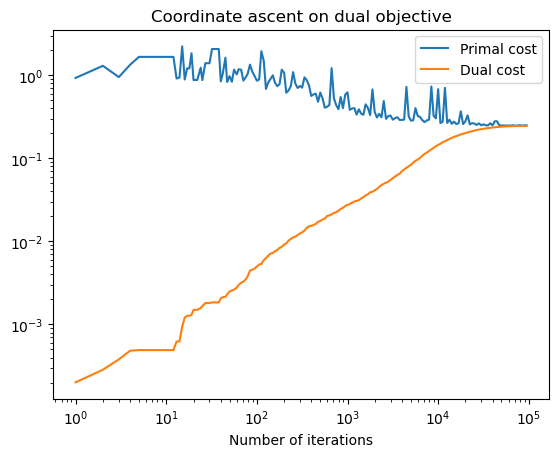

Final training accuracy = 91.39 %
Training time: 1.9 seconds 


In [188]:
# Notice that the gap is going to 0
def coordinate_descent_for_svm_demo(y, X):
    max_iter = int(1e5)
    xs = np.unique(np.round(np.logspace(0, 5, 201)))[:-1]
    lambda_ = 5e1
    p_costs, d_costs = [], []

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    start = time.time()

    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0, num_examples - 1)

        w, alpha = calculate_coordinate_update(y, X, lambda_, alpha, w, n)

        if it in xs:
            # primal objective
            primal_value = calculate_primal_objective(y, X, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, X, w, alpha, lambda_)
            # store values
            p_costs += [primal_value]
            d_costs += [dual_value]

    end = time.time()
    plt.figure()
    plt.title("Coordinate ascent on dual objective")
    plt.loglog(xs, p_costs, label="Primal cost")
    plt.loglog(xs, d_costs, label="Dual cost")
    plt.xlabel("Number of iterations")
    plt.legend()
    plt.show()

    print(
        "Final training accuracy = {l} %".format(
            l=np.round(100 * calculate_accuracy(y, X, w), 2)
        )
    )
    print("Training time: " + str(np.round(end - start, 1)) + " seconds ")


coordinate_descent_for_svm_demo(y, X)

#### The gap between the primal cost and the dual cost should go to 0 !